In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pwd

'/content'

In [3]:
%cd "/content/drive/MyDrive/LSTM"

/content/drive/MyDrive/LSTM


In [4]:
#Import Part
!pip install transformers
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import pickle

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

In [6]:
#Load dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

english_sentences_train = df_train['en_text'].values
persian_sentences_train = df_train['fa_text'].values

english_sentences_test = df_test['en_text'].values

In [7]:
# Load pre-trained BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [8]:
# Function to get BERT embeddings
def get_bert_embeddings(sentences, max_length=20):
    embeddings = []
    for sentence in sentences:
        inputs = bert_tokenizer(sentence, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embeddings.append(outputs.last_hidden_state.squeeze(0).numpy())
    return np.array(embeddings)

In [9]:
#Get BERT embeddings for English sentences(train data)
max_length = 20
english_embeddings_train = get_bert_embeddings(english_sentences_train, max_length=max_length)

In [10]:
#Get BERT embeddings for test sentences
english_embeddings_test = get_bert_embeddings(english_sentences_test, max_length=max_length)

In [11]:
#Tokenize and pad Persian sentences(target sequences)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(persian_sentences_train)
persian_sequences_train = tokenizer.texts_to_sequences(persian_sentences_train)
persian_sequences_train = pad_sequences(persian_sequences_train, maxlen=max_length, padding='post')

In [12]:
#Save the tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
#Get vocabulary size for Persian
num_persian_tokens = len(tokenizer.word_index) + 1

#Split the dev data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(english_embeddings_train, persian_sequences_train, test_size=0.2, random_state=42)

In [ ]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(512, input_shape=(max_length, english_embeddings_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_persian_tokens, activation='softmax'))

#Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Train the model
history = model.fit(X_train, np.expand_dims(y_train, axis=-1), epochs=15, validation_data=(X_val, np.expand_dims(y_val, axis=-1)), batch_size=32)

#Save the model
model.save('model_lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
 15/164 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.5900 - loss: 5.7424

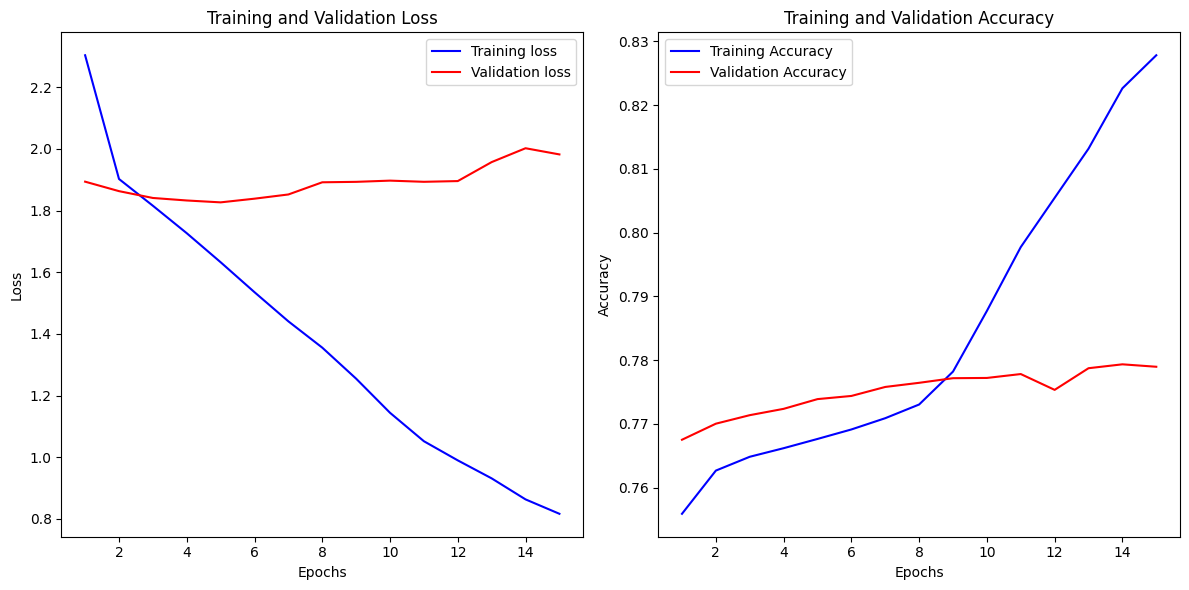

In [ ]:
# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Training and Validation Accuracy.jpg',dpi = 100)
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
#Function to translate English sentences
def translate(sentence):
    embeddings = get_bert_embeddings([sentence], max_length)
    predictions = model.predict(embeddings)

    predicted_sentence = []
    for i in range(predictions.shape[1]):
        predicted_token = np.argmax(predictions[0, i])
        if predicted_token != 0:
            predicted_word = tokenizer.index_word.get(predicted_token, '')
            predicted_sentence.append(predicted_word)
    return ' '.join(predicted_sentence)

In [ ]:
#Translate test sentences and save to CSV
translated_sentences = []
for sentence in english_sentences_test:
    translated_sentence = translate(sentence)
    translated_sentences.append(translated_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

In [ ]:
#Save predictions to a CSV file
df_test['translated_text'] = translated_sentences
df_test.to_csv('test_predictions.csv', index=False)